<a href="https://colab.research.google.com/github/rodgpt/MAR_FUTURA/blob/Optimization-but-with-NDSI-package/NDSI/NDSI_Sites_Comparisson_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code compares the NDSI and bio-anthro energy for different cases. It allows to set a date range

This notebook is structured to run on Google Colab using a Python runtime with R via rpy2.
Three changes to run locally vs run in colab:
1. Remove the from google.colab import drive line
2. Remove the drive.mount("/content/gdrive") line
3. Change the path to the data folder in the third cell

In [1]:
#This cell mounts the google drive and install packages to be able to run the rest in R, because the whole runtime is in phyton

#Just for google colab
#from google.colab import drive
#drive.mount('/content/drive')

!pip install rpy2
%load_ext rpy2.ipython


Error importing in API mode: ImportError("dlopen(/Users/rodrigo/Desktop/CODES/.venv/lib/python3.9/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <08761B8B-0767-3CA6-9437-5468D1CD700F> /Users/rodrigo/Desktop/CODES/.venv/lib/python3.9/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.
/Users/rodrigo/Desktop/CODES/.venv/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:96: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded,

In [ ]:
%%R

install.packages("tuneR")
install.packages("seewave")
install.packages("dplyr")
install.packages("purrr")
install.packages("ggplot2")
install.packages("scales")
install.packages("lubridate")
install.packages("tidyr")
install.packages("soundecology")
install.packages("beepr")
install.packages("future")
install.packages("future.apply")

library(tuneR)
library(seewave)
library(dplyr)
library(purrr)
library(ggplot2)
library(scales)
library(lubridate)
library(tidyr)
library(soundecology)
library(beepr)
library(future)
library(future.apply)

  |======================================================================| 100%San Antonio 38 |   0.3% | 1/384 | avg 0s/file | ETA 09:15:11 | ~0s remaining\nSan Antonio 38 |   3.1% | 12/384 | avg 0s/file | ETA 09:16:20 | ~1m06s remaining\nSan Antonio 38 |   6.2% | 24/384 | avg 0s/file | ETA 09:16:19 | ~1m04s remaining\nSan Antonio 38 |   9.1% | 35/384 | avg 0s/file | ETA 09:16:20 | ~1m02s remaining\nSan Antonio 38 |  12.0% | 46/384 | avg 0s/file | ETA 09:16:21 | ~1m01s remaining\nSan Antonio 38 |  15.1% | 58/384 | avg 0s/file | ETA 09:16:21 | ~59s remaining\nSan Antonio 38 |  18.2% | 70/384 | avg 0s/file | ETA 09:16:21 | ~57s remaining\nSan Antonio 38 |  21.1% | 81/384 | avg 0s/file | ETA 09:16:22 | ~55s remaining\nSan Antonio 38 |  24.2% | 93/384 | avg 0s/file | ETA 09:16:21 | ~53s remaining\nSan Antonio 38 |  27.1% | 104/384 | avg 0s/file | ETA 09:16:21 | ~51s remaining\nSan Antonio 38 |  30.2% | 116/384 | avg 0s/file | ETA 09:16:21 | ~49s remaining\nSan Antonio 38 |  33.3% | 128/384

Found 15612 files in San Antonio 38 (searching recursively, case-insensitive)
Found 15185 files in Ventanas 36 (searching recursively, case-insensitive)
Found 15164 files in Zapallar 34 (searching recursively, case-insensitive)
Found 18496 files in Las Cruces 26 (searching recursively, case-insensitive)
Found 17707 files in Matanzas 32 (searching recursively, case-insensitive)
Saved to: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/ndsi_casestudies_20251121-20251124_anthro_1000-2000_bio_2000-3000.csv
In addition: Warning message:
Removed 1920 rows containing missing values or values outside the scale range
(`geom_line()`). 


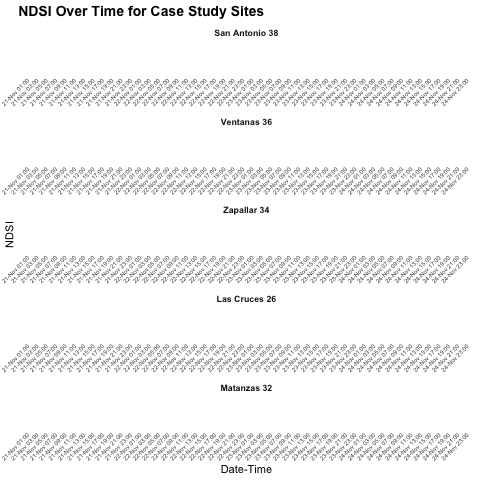

In [6]:
%%R

##For running locally (Rod)
dirs_sites <- list(
  "San Antonio 38" = "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38",
  "Ventanas 36" = "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Ventanas/07-11-25/36",
  "Zapallar 34" = "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Zapallar/07-11-25/34",
  "Las Cruces 26" = "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/LasCruces/12-11-25/26",
  "Matanzas 32" = "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"
)
output_dir <- "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults"

##For running in Colab
#dirs_sites <- list(
 # "San Antonio 38" = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38", ### este esta mal. En GD lo tengo como 38 en san antonio, pero enverdad no se que es
 # "Ventanas 36" = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Ventanas/07-11-25/36",       ### esta esta bien
  #"Zapallar 34" = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Zapallar/07-11-25/34",       ### esta esta bien
  #"Las Cruces 26" = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/LasCruces/12-11-25/26",    ### este esta mal. En GD lo tengo como 26 en las cruces, pero enverdad es san antonio
  #"Matanzas 32" = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"        ### este esta bien.
#)

#output_dir <- "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/NDSIResults"

segment_sec <- 60
anthro_band <- c(1000, 2000)
bio_band    <- c(2000, 3000) #c(2000, 3000)
tz <- "UTC"
analysis_duration <- NA
files_per_folder <- NA
files_per_hour <- 4
output_csv <- "ndsi_casestudies_results.csv"

start_date <- as.POSIXct("2025-11-21 00:00:00", tz = tz)
end_date   <- as.POSIXct("2025-11-24 23:59:59", tz = tz)

workers <- max(1, parallel::detectCores() - 1)
future::plan(future::multisession, workers = workers)

extract_datetime <- function(filename) {
  dt_str <- sub("^(?:ST_\\d+_)?(\\d{8}_\\d{6})\\.WAV$", "\\1", basename(filename), ignore.case = TRUE)
  as.POSIXct(dt_str, format = "%Y%m%d_%H%M%S", tz = tz)
}

calculate_ndsi <- function(wave_obj) {
  spec <- NULL
  suppressWarnings(suppressMessages(invisible(capture.output({
    spec <- seewave::spectro(
      wave_obj,
      f = wave_obj@samp.rate / 1000,
      wl = 2048,
      ovlp = 50,
      wn = "hanning",
      norm = FALSE,
      plot = FALSE
    )
  }))))

  if (is.null(spec) || is.null(spec$amp) || is.null(spec$freq)) {
    return(list(
      ndsi = NA_real_,
      anthro_energy = NA_real_,
      bio_energy = NA_real_
    ))
  }

  f <- spec$freq * 1000
  Sxx <- spec$amp

  anthro_idx <- which(f >= anthro_band[1] & f <= anthro_band[2])
  bio_idx <- which(f >= bio_band[1] & f <= bio_band[2])

  if (length(anthro_idx) == 0 || length(bio_idx) == 0) {
    return(list(
      ndsi = NA_real_,
      anthro_energy = NA_real_,
      bio_energy = NA_real_
    ))
  }

  anthro_power <- mean(Sxx[anthro_idx, , drop = FALSE], na.rm = TRUE)
  bio_power <- mean(Sxx[bio_idx, , drop = FALSE], na.rm = TRUE)

  denom <- anthro_power + bio_power
  if (!is.finite(denom) || denom == 0) {
    return(list(
      ndsi = NA_real_,
      anthro_energy = anthro_power,
      bio_energy = bio_power
    ))
  }

  ndsi <- (bio_power - anthro_power) / denom

  list(
    ndsi = ndsi,
    anthro_energy = anthro_power,
    bio_energy = bio_power
  )
}

.evenly_spaced_indices <- function(n, k) {
  if (k <= 0) return(integer(0))
  if (n <= k) return(seq_len(n))
  idx <- round((seq_len(k) * (n + 1)) / (k + 1))
  idx <- pmax(1L, pmin(n, idx))
  sort(unique(idx))
}

.fmt_secs <- function(secs) {
  if (!is.finite(secs) || is.na(secs) || secs < 0) return("NA")
  secs <- as.integer(round(secs))
  h <- secs %/% 3600
  m <- (secs %% 3600) %/% 60
  s <- secs %% 60
  if (h > 0) return(sprintf("%dh%02dm%02ds", h, m, s))
  if (m > 0) return(sprintf("%dm%02ds", m, s))
  sprintf("%ds", s)
}

.in_notebook <- function() {
  nzchar(Sys.getenv("JPY_PARENT_PID")) ||
    nzchar(Sys.getenv("COLAB_GPU")) ||
    nzchar(Sys.getenv("COLAB_RELEASE_TAG"))
}

process_site <- function(directory, label) {
  files <- list.files(directory, pattern = "\\.wav$", full.names = TRUE, recursive = TRUE, ignore.case = TRUE)
  message("Found ", length(files), " files in ", label, " (searching recursively, case-insensitive)")

  if (length(files) == 0) {
    return(tibble(
      Site = character(),
      Time = as.POSIXct(character()),
      NDSI = numeric(),
      Anthro_Energy = numeric(),
      Bio_Energy = numeric()
    ))
  }

  files <- sort(files)

  if (!is.na(files_per_hour) && (is.na(files_per_hour) || files_per_hour <= 0)) {
    stop("`files_per_hour` must be NA or a positive number.")
  }

  file_dt <- purrr::map_df(files, ~tibble(
    filepath = .x,
    start_dt = extract_datetime(.x)
  ))

  if (nrow(file_dt) > 0) {
    if (!is.na(start_date)) {
      file_dt <- dplyr::filter(file_dt, start_dt >= (start_date - segment_sec))
    }
    if (!is.na(end_date)) {
      file_dt <- dplyr::filter(file_dt, start_dt <= end_date)
    }
  }

  file_dt <- dplyr::arrange(file_dt, start_dt)

  if (!is.na(files_per_hour)) {
    k <- as.integer(files_per_hour)
    file_dt <- file_dt %>%
      mutate(.hour = lubridate::floor_date(start_dt, unit = "hour")) %>%
      group_by(.hour) %>%
      arrange(start_dt, .by_group = TRUE) %>%
      group_modify(function(.x, .g) {
        idx <- .evenly_spaced_indices(nrow(.x), k)
        .x[idx, , drop = FALSE]
      }) %>%
      ungroup() %>%
      select(-.hour)
  }

  files <- file_dt$filepath

  if (!is.na(files_per_folder)) {
    files <- head(files, files_per_folder)
  }

  if (length(files) == 0) {
    return(tibble(
      Site = character(),
      Time = as.POSIXct(character()),
      NDSI = numeric(),
      Anthro_Energy = numeric(),
      Bio_Energy = numeric()
    ))
  }

  pb <- utils::txtProgressBar(min = 0, max = length(files), style = 3)
  on.exit({
    try(close(pb), silent = TRUE)
  }, add = TRUE)

  t0 <- Sys.time()
  last_print <- Sys.time()

  results <- vector("list", length(files))
  out_k <- 0L

  for (i in seq_along(files)) {
    fp <- files[[i]]

    utils::setTxtProgressBar(pb, i)
    flush.console()

    now <- Sys.time()
    if (i == 1L || i == length(files) || as.numeric(difftime(now, last_print, units = "secs")) >= 2) {
      elapsed <- as.numeric(difftime(now, t0, units = "secs"))
      avg_sec <- elapsed / i
      remaining <- avg_sec * (length(files) - i)
      pct <- 100 * i / length(files)
      eta <- now + remaining

      cat(sprintf(
        "%s | %5.1f%% | %d/%d | avg %s/file | ETA %s | ~%s remaining\\n",
        label,
        pct,
        i,
        length(files),
        .fmt_secs(avg_sec),
        format(eta, "%H:%M:%S"),
        .fmt_secs(remaining)
      ))
      flush.console()

      last_print <- now
    }

    start_dt <- extract_datetime(fp)

    wav <- tryCatch(readWave(fp), error = function(e) {
      warning("Skipping unreadable file: ", fp)
      return(NULL)
    })
    if (is.null(wav)) next

    dur_sec <- length(wav@left) / wav@samp.rate
    seg_len <- min(segment_sec, dur_sec)
    if (!is.finite(seg_len) || seg_len <= 0) next

    max_start <- max(0, dur_sec - seg_len)
    starts <- seq(0, max_start, by = seg_len)

    for (st in starts) {
      segment_time <- start_dt + st

      if (!is.na(start_date) && segment_time < start_date) {
        next
      }
      if (!is.na(end_date) && segment_time > end_date) {
        break
      }

      seg <- tryCatch(
        extractWave(wav, from = st, to = st + seg_len, xunit = "time"),
        error = function(e) return(NULL)
      )
      if (is.null(seg)) next

      ndsi_res <- calculate_ndsi(seg)

      out_k <- out_k + 1L
      results[[out_k]] <- tibble(
        Site = label,
        Time = segment_time,
        NDSI = ndsi_res$ndsi,
        Anthro_Energy = ndsi_res$anthro_energy,
        Bio_Energy = ndsi_res$bio_energy
      )
    }
  }

  cat("\\n")

  if (out_k == 0L) {
    return(tibble(
      Site = character(),
      Time = as.POSIXct(character()),
      NDSI = numeric(),
      Anthro_Energy = numeric(),
      Bio_Energy = numeric()
    ))
  }

  bind_rows(results[seq_len(out_k)])
}

anthro_tag <- paste0("anthro_", anthro_band[1], "-", anthro_band[2])
bio_tag <- paste0("bio_", bio_band[1], "-", bio_band[2])

date_tag <- if (!is.na(start_date) && !is.na(end_date)) {
  paste0(format(start_date, "%Y%m%d"), "-", format(end_date, "%Y%m%d"))
} else {
  "alltime"
}

dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

all_results_list <- list()

for (label in names(dirs_sites)) {
  res <- tryCatch(
    process_site(dirs_sites[[label]], label),
    error = function(e) {
      warning("Site failed: ", label, " - ", conditionMessage(e))
      return(tibble(
        Site = character(),
        Time = as.POSIXct(character()),
        NDSI = numeric(),
        Anthro_Energy = numeric(),
        Bio_Energy = numeric()
      ))
    }
  )
  all_results_list[[label]] <- res
}

all_results <- bind_rows(all_results_list)

if (!exists("all_results") || nrow(all_results) == 0) {
  stop("No WAV files found in the provided directories and date range. Please verify the paths in `dirs_sites` and the date filters.")
}

output_csv_all <- file.path(output_dir, paste0(
  "ndsi_casestudies_", date_tag, "_", anthro_tag, "_", bio_tag, ".csv"
))
write.csv(all_results, output_csv_all, row.names = FALSE)
message("Saved to: ", output_csv_all)

summary_stats <- all_results %>%
  group_by(Site) %>%
  summarize(
    Segments  = n(),
    Mean_NDSI = mean(NDSI, na.rm = TRUE),
    SD_NDSI   = sd(NDSI, na.rm = TRUE)
  )
print(summary_stats)

plot_data <- all_results

plot_data$Site <- factor(plot_data$Site, levels = names(dirs_sites))

## NDSI time-series plot
p_ndsi <- ggplot(plot_data, aes(x = Time, y = NDSI, color = Site)) +
  geom_line(size = 0.8) +
  facet_wrap(~Site, ncol = 1, scales = "free_x") +
  scale_x_datetime(
    date_labels = "%d-%b %H:%M",
    date_breaks = "2 hour",
    expand = expansion(mult = c(0.01, 0.01))
  ) +
  labs(
    title = "NDSI Over Time for Case Study Sites",
    x = "Date-Time",
    y = "NDSI"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold", size = 14),
    axis.text.x = element_text(
      angle = 45,
      hjust = 1,
      vjust = 1,
      size = 6,
      margin = margin(t = 5)
    ),
    strip.text = element_text(face = "bold")
  )

print(p_ndsi)

## NDSI quadrant table (percentage of time per site in each quadrant)
ndsi_quadrant_table <- plot_data %>%
  mutate(
    NDSI_Quadrant = case_when(
      NDSI >= 0.5  & NDSI <= 1   ~ "[0.5, 1]",
      NDSI >  0    & NDSI <  0.5 ~ "(0, 0.5)",
      NDSI >= -0.5 & NDSI <= 0   ~ "[-0.5, 0]",
      NDSI >= -1   & NDSI < -0.5 ~ "[-1, -0.5)",
      TRUE ~ NA_character_
    )
  ) %>%
  filter(!is.na(NDSI_Quadrant)) %>%
  group_by(Site, NDSI_Quadrant) %>%
  summarise(
    Segments = n(),
    .groups = "drop_last"
  ) %>%
  mutate(
    Total_Segments = sum(Segments),
    Percent_Time = 100 * Segments / Total_Segments
  ) %>%
  ungroup()

print(ndsi_quadrant_table)

beepr::beep(3)
